# Using Tensorflow DALI plugin: simple example

### Overview

Using our DALI data loading and augmentation pipeline with Tensorflow is pretty simple.

We can summarize the integration in 3 steps :

- Defining a DALI Pipeline
- Using `pipeline.serialize` and giving the serialized pipeline to `DALIIterator` op
- Instatiate the op in TensorFlow graph and use it

### Defining the data loading pipeline

First we start by defining some parameters for DALI and Tensorflow.

We will use a subsample of Imagenet stored in a MXNet's RecordIO for this tutorial. For details on how to use `MXNetReader` as well as other readers please see other [examples](..).

In [1]:
base = "/data/imagenet/train-480-val-256-recordio/"

idx_files = [base + "val.idx"]
rec_files = [base + "val.rec"]

BATCH_SIZE = 32
DEVICES = 8
ITERATIONS = 32
BURNIN_STEPS = 16

In order to use DALI we need those 3 imports:

In [2]:
from nvidia.dali.pipeline import Pipeline
import nvidia.dali.ops as ops
import nvidia.dali.types as types

Then we can define our pipeline by declaring `RN50Pipeline` as as sublass of `dali.pipeline.Pipeline`.
We declare the operators the pipeline will need in the constructor. Then we define the graph in `define_graph`.

This is the usual DALI Pipeline creation.
For more information about DALI Pipeline, please take a look at [Getting Started notebook](../getting started.ipynb).

Note again that we are using `MXNetReader` that reads MXNet's dataset format [RecordIO](http://mxnet.incubator.apache.org/architecture/note_data_loading.html). You can change it to other Reader ops to use any of the supported dataset format.

In [3]:
class RN50Pipeline(Pipeline):
    def __init__(self, batch_size, num_threads, device_id, num_gpus):
        super(RN50Pipeline, self).__init__(batch_size,
                                         num_threads,
                                         device_id)
        self.input = ops.MXNetReader(path = rec_files, index_path = idx_files,
                                     shard_id = device_id, num_shards = num_gpus)

        self.decode = ops.nvJPEGDecoder(device = "mixed", output_type = types.RGB)
        self.resize = ops.Resize(device = "gpu",
                                 image_type = types.RGB,
                                 interp_type = types.INTERP_LINEAR)
        self.cmn = ops.CropMirrorNormalize(device = "gpu",
                                            output_dtype = types.FLOAT,
                                            crop = (224, 224),
                                            image_type = types.RGB,
                                            mean = [128., 128., 128.],
                                            std = [1., 1., 1.])
        self.res_uniform = ops.Uniform(range = (256.,480.))
        self.uniform = ops.Uniform(range = (0.0, 1.0))
        self.cast = ops.Cast(device = "gpu",
                             dtype = types.INT32)

    def define_graph(self):
        inputs, labels = self.input(name="Reader")
        images = self.decode(inputs)
        images = self.resize(images, resize_shorter = self.res_uniform())
        output = self.cmn(images, crop_pos_x = self.uniform(),
                          crop_pos_y = self.uniform())
        output = self.cast(output)
        return (output, labels.gpu())

Next, we instatiate the pipelines with the right parameters. We will create one pipeline per GPU, by specifying the right `device_id` for each pipeline.

The difference is that instead of calling `pipeline.build` and using it, we will get the serialized pipeline
with `serialize` method (for more information about serializing pipelines please refer to [this tutorial](../serialization.ipynb)). We can then delete the pipelines to maximize the available memory.


In [4]:
pipes = [RN50Pipeline(batch_size=BATCH_SIZE, num_threads=2, device_id = device_id, num_gpus = DEVICES) for device_id in range(DEVICES)]
serialized_pipes = [pipe.serialize() for pipe in pipes]
del pipes

### Using DALI TensorFlow plugin

Let's start by importing Tensorflow and the DALI Tensorflow plugin as `dali_tf`.

In [5]:
import tensorflow as tf
import nvidia.dali.plugin.tf as dali_tf
import time

We can now use `nvidia.dali.plugin.tf.DALIIterator()` method to get the Tensorflow Op that will produce the tensors we will
use in the Tensorflow graph.

For each DALI serialized pipeline, we use `daliop` that returns a Tensorflow tensor tuple that we will store in `image, label`. Each one is using a different `tf.device`.

In [6]:
daliop = dali_tf.DALIIterator()

images = []
labels = []
for d in range(DEVICES):
    with tf.device('/gpu:%i' % d):
        image, label = daliop(serialized_pipeline = serialized_pipes[d],
            shapes = [[BATCH_SIZE, 3, 224, 224], []],
            dtypes = [tf.int32, tf.float32])

        images.append(image)
        labels.append(label)

(32, 3, 224, 224)
<unknown>
(32,)


### Using the tensors in a simple Tensorflow graph

We will use `images` and `labels` tensors list in our Tensorflow graph definition.
Then run a very simple _one op graph_ session that will output the batch of images and labels.  

In [7]:
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.8)
config = tf.ConfigProto(gpu_options=gpu_options)

with tf.Session(config=config) as sess:
    all_img_per_sec = []
    total_batch_size = BATCH_SIZE * DEVICES
    
    for i in range(ITERATIONS):
        start_time = time.time()
        
        # The actual run with our dali_tf tensors
        res = sess.run([images, labels])
        
        elapsed_time = time.time() - start_time
        img_per_sec = total_batch_size / elapsed_time
        if i > BURNIN_STEPS:
            all_img_per_sec.append(img_per_sec)
            print("\t%7.1f img/s" %  img_per_sec)

    print("Total average %7.1f img/s" % (sum(all_img_per_sec) / len(all_img_per_sec)))

	 4361.0 img/s
	 4902.8 img/s
	 4562.3 img/s
	 4973.6 img/s
	 4595.1 img/s
	 4298.8 img/s
	 4754.8 img/s
	 4241.9 img/s
	 4525.5 img/s
	 4797.6 img/s
	 4641.0 img/s
	 4400.4 img/s
	 4282.6 img/s
	 4792.6 img/s
	 4533.8 img/s
Total average  4577.6 img/s


Let us check the output images with their augmentations! Tensorflow outputs numpy arrays, so we can visualize them easily with `matplotlib`.

We define a `show_images` helper function that will display a sample of our batch.

The batch layout is NCHW so we use transpose to get HWC images, that `matplotlib` can show.

In [8]:
from __future__ import division
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
%matplotlib inline

def show_images(image_batch, nb_images):
    columns = 4
    rows = (nb_images + 1) // (columns)
    fig = plt.figure(figsize = (32,(32 // columns) * rows))
    gs = gridspec.GridSpec(rows, columns)
    for j in range(nb_images):
        plt.subplot(gs[j])
        plt.axis("off")
        img = res[0][0][j].transpose((1,2,0)) + 128
        plt.imshow(img.astype('uint8'))

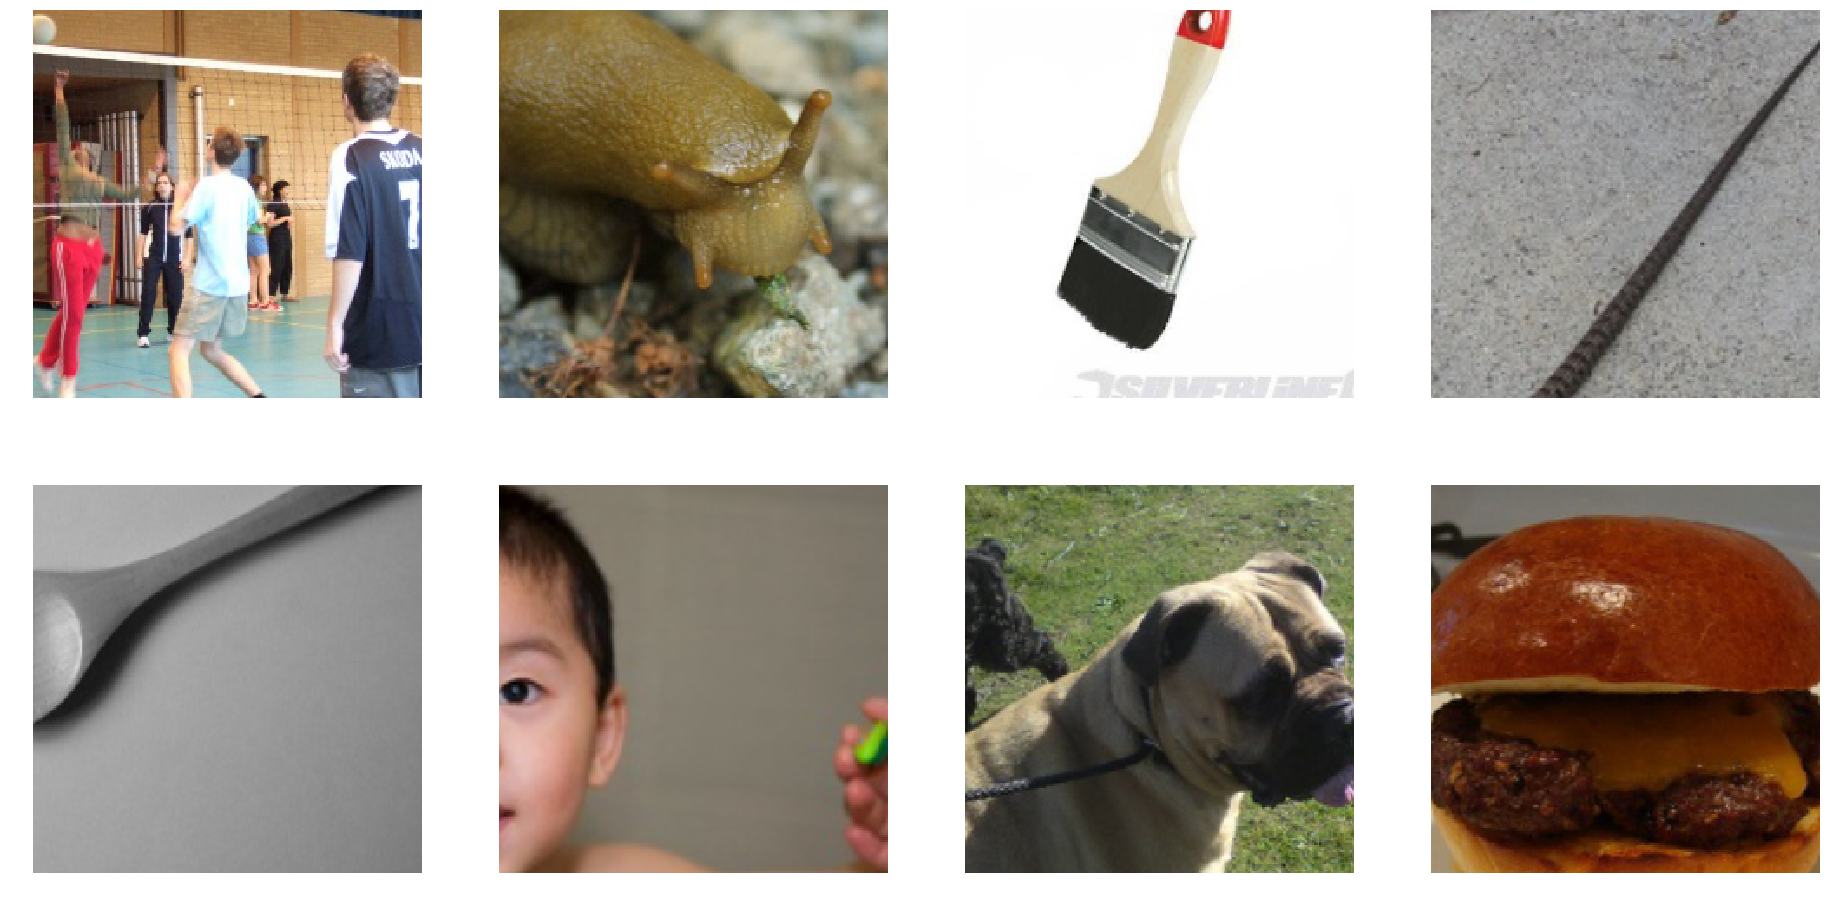

In [9]:
show_images(images, 8)